# Ma formation : Opencv 

## import package

In [3]:
from asyncio import threads
from pickletools import uint8
import cv2
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import PySimpleGUI as sg


## Functions

In [4]:
def getPerspective(img,location,height = 900, width = 900):
    cornersOg = np.float32([location[0], location[3], location[1], location[2]])
    cornersFlattened = np.float32([[0, 0], [width, 0], [0, height], [width, height]])
    transformMatrix = cv2.getPerspectiveTransform(cornersOg,cornersFlattened)
    result = cv2.warpPerspective(img,transformMatrix,(width,height))
    return result

## UI For selcting mode

In [5]:
#Ui should let user chose between video camera or already rendered picture
layout = [[sg.Text("Select an input video or image")], [sg.Button("Webcam")],[sg.Button("Image")]]

# Create the window
window = sg.Window("Sudoku solver", layout)
flagMode = "None"
# Create an event loop
while True:
    event, values = window.read()
    # End program if user closes window or
    # presses the OK button
    if event == "Webcam":
        flagMode = "Webcam"
        break
    if event == "Image" :
        flagMode = "Image"
        break
    if event == sg.WIN_CLOSED:
        break

window.close()
print(flagMode)

Image


In [6]:
if flagMode == "Webcam":
    print("Using webcam")
    #Create the webcam object using the default cam (0)
    cam = cv2.VideoCapture(0)
    if not cam.isOpened():
        raise IOError("Error opening cam")

    while True:
        #Fetch the image of the cam
        [ret,image] = cam.read()
        if not ret:
            raise IOError("No image fetched")
        #Convert it to grayScale
        grayImage = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

        #Tresholding
        t1 = cv2.adaptiveThreshold(grayImage,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,9,4)

        #Contouring
        contours, Hierarchy = cv2.findContours(t1,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
        for i,contour in enumerate(contours):
            area = cv2.contourArea(contour)
            if area>16000:
                approx = cv2.approxPolyDP(contour,0.01*cv2.arcLength(contour,True),True)
                if len(approx == 4):
                    mask = np.zeros(image.shape,np.uint8)
                    cv2.drawContours(image,contours,i,(255,255,0),2)

        #Showing images
        cv2.imshow("Og", image)
        cv2.imshow("grayScale", grayImage)
        cv2.imshow("treshold", t1)

        c = cv2.waitKey(1)
        #Leave the loop whe "Esc" is pressed
        if c == 27:
            print("Esc pressed")
            break

    cam.release()
    cv2.destroyAllWindows()
if flagMode == "Image":
    print("Using image")
    
    #Open image
    path = "assets/gridBrut.png"
    image = cv2.imread(path)
    
    #Convert it to grayScale
    grayImage = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

    #Gaussian filtering
    grayBlur = cv2.GaussianBlur(grayImage,(3,3),1)
    
    #Tresholding
    t1 = cv2.adaptiveThreshold(grayBlur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,9,4)

    #Contouring
    contours, Hierarchy = cv2.findContours(t1,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    for i,contour in enumerate(contours):
        area = cv2.contourArea(contour)
        if area>16000:
            approx = cv2.approxPolyDP(contour,0.01*cv2.arcLength(contour,True),True)
            if len(approx == 4):
                mask = np.zeros(image.shape,np.uint8)
                cv2.drawContours(image,contours,i,(255,255,0),2)


    


Using image


True

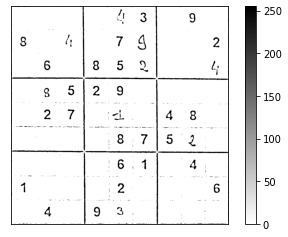

In [7]:
#Flatten the grid
flatImage = getPerspective(grayImage,approx)
flatImageBlur = cv2.GaussianBlur(flatImage,(9,9),5)
flatImageTresh = cv2.adaptiveThreshold(flatImageBlur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,9,3)
plt.imshow(flatImageTresh,cmap='binary')
plt.xticks([])
plt.yticks([])
plt.colorbar()
cv2.imwrite("gridBrut.png",grayImage)
cv2.imwrite("grid.png",flatImage)


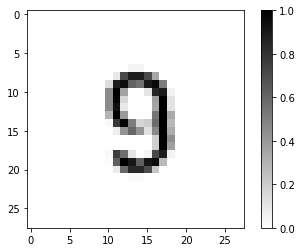

In [8]:
#Go through the sudoku grid
sudoku = np.zeros((9,9),np.int8)
allInput = []

for idx,x in np.ndenumerate(sudoku):
    i = idx[0]
    j = idx[1]
    cellImage = flatImageTresh[i*100+5:i*100+90,j*100+5:j*100+90]
    cellImageBlurred = cv2.GaussianBlur(cellImage,(3,3),2)
    cellImageInput = cv2.resize(cellImageBlurred,(28,28))
    input = np.asarray(cellImageInput,dtype=np.float32)
    inputNormalized = input/255.0
    #inputNormalized = tf.keras.utils.normalize(input)

    allInput.append(inputNormalized)
plt.imshow(allInput[7],cmap='binary')
plt.colorbar()

## Load the model

In [9]:
#Load the MNIST model
MNIST_model = tf.keras.models.load_model('saved_model/MNIST')

In [10]:
arg = tf.convert_to_tensor(allInput)
probability_model = tf.keras.Sequential([MNIST_model,tf.keras.layers.Softmax()])
predictions = probability_model.predict(arg)


3/3 [==============================] - 0s 3ms/step


In [11]:
allRes = np.zeros(shape=81)
for i in range(len(predictions)):
    res = np.argmax(predictions[i])
    allRes[i] = res
    #print(i," : ",res)
allResReshape = np.reshape(allRes, (9,9))

#     plt.subplot(9,9,i+1)
#     plt.imshow(allInput[i],cmap=plt.cm.binary)
#     plt.xticks([])
#     plt.yticks([])
#     plt.xlabel(res)
# plt.subplots_adjust(left=0.1,
#                     bottom=0.1, 
#                     right=0.9, 
#                     top=0.9, 
#                     wspace=0.4, 
#                     hspace=1.7)
# plt.show()

## UI to correct the digits

In [14]:
##Create PySimpleGUI to update the wrong digits (try table)
testVal = [[1,2,3],[4,5,6],[7,8,9]]
headings =  ['1','2','3']
layout = [[sg.Text("Correct mistakes")], [sg.Table(values = testVal,headings=headings)],[sg.Button("Done")]]

# Create the window
window = sg.Window("Sudoku solver", layout)
# Create an event loop
while True:
    event, values = window.read()
    # End program if user closes window or
    # presses the OK button
    if event == "Done":
        break
    if event == sg.WIN_CLOSED:
        break

window.close()
print(flagMode)

SystemExit: 

c:\Users\hrevois\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py:3406: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
